In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt

# '"text.usetex": True' causes  runtime errors when plotting.
plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": "Computer Modern",
    "font.size": 22})


#import numpy as np
from scipy import integrate as integrate
import math

from astropy.cosmology import Planck18 # Planck 2018 cosmology, see https://arxiv.org/abs/1807.06209
import astropy.units as au # Astrophysical units

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

import jax
import jax_cosmo as jc
import jax.numpy as np

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

Using CAMB 1.4.0 installed at /home/carter/.venv.camb/lib/python3.10/site-packages/camb
JAX version: 0.4.12
jax-cosmo version: 0.1.0


In [2]:
# Useful constants
H0_INV = 2997.8 #h^{-1} Mpc
GAMMA_INT = .2

## Describe survey and cosmology

In [3]:
def convert_cosmology_camb_to_jc(pars : camb.CAMBparams):
    h = pars.H0/100
    results = camb.get_results(pars)
    sig8 = results.get_matter_transfer_data().sigma_8
    pars_jc = jc.Cosmology(pars.omch2/h**2, pars.ombh2/h**2, h,
                           pars.InitPower.ns, sig8, pars.omk,
                           pars.DarkEnergy.w, pars.DarkEnergy.wa)
    return pars_jc

In [4]:
surveyParams = {
    'dz' : 3,
    'z' : 2,
    'omSurvey' : 2*math.pi, #Survey area, deg^2
    'n_objects' : 1e-2, #Average number density of galaxies, h^3Mpc^-3
}
surveyParams['f_sky'] = surveyParams['omSurvey']/(4*math.pi)

pars_camb = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
pars_jc = convert_cosmology_camb_to_jc(pars_camb)

# 

# Matter power spectrum

For the matter power spectrum, 

In [5]:
def E_of_z(z : float,
           omM : float = .3, omL : float = .7, omR : float = 0, w : float=-1):
    omK = 1-(omM+omL+omR)
    return (omM*(1+z)**3+omL*(1+z)**(3*(1+w))+omR*(1+z)**4+omK*(1+z)**2)**.5

def r_of_z_dimensionless(z, omM = .3, omL = .7, omR = 0, w=-1):
    if(z==0):
        return 0
    return integrate.quad(lambda x: E_of_z(x, omM = omM, omL = omL, omR = omR, w=w)**-1, 0, z)[0]

def get_FKP_errorbars(k, Pk_theory, dk, z, dz, om_survey, n):
    """Generate Feldman-Kaiser-Peacock error bars for a point (k,z,P(k,z))
    from a survey with given dk, dz, number density of galaxies n and fractional sky coverage Omega_survey.
    Eq. (22-24) in arXiv:1007.0757"""

    dV_survey = om_survey*r_of_z_dimensionless(z)**2/E_of_z(z)*dz #r=r(z) is the comoving distance, H=H(z), simply hubble parameter
    dV_eff = (n*Pk_theory/(1+n*Pk_theory))**2*dV_survey #P = P(k,z), n = n(z) = number density of galaxies
    sigma2 = 4*math.pi**2*Pk_theory**2/(k**2*dk*dV_eff)*H0_INV**-3
    sigma = sigma2**.5
    return(sigma)

def get_Pk_errorbars(k_bins, pk_interp, 
                                cosmoParams : camb.CAMBparams = None, surveyParams : dict = None):
    """Returns NDarray of shape (n_bins, 5) where array elements are [x, y, y_err, x-_err, x+_err]
    Survey params should include keys 'z', 'dz', 'omSurvey', 'n_objects'."""
    H0 = cosmoParams.H0
    h = H0/100 #Dimensionless h, used to recover omega_matter, etc. from ombh2.
    omM = cosmoParams.ombh2/h**2+cosmoParams.omch2/h**2
    omL = 1-cosmoParams.omk-omM

    shotnoise_const = 1/surveyParams['n_objects']

    k_sample = (k_bins[:-1]*k_bins[1:])**.5
    dk  = k_bins[1:]-k_bins[:-1]

    pk = pk_interp.P(surveyParams['z'],k_sample)

    error_y = (get_FKP_errorbars(k_sample, pk, dk, 
                                 surveyParams['z'], surveyParams['dz'], 
                                 surveyParams['omSurvey'], surveyParams['n_objects'])**2 + shotnoise_const**2)**.5
    errorbars = np.array([k_sample, pk+shotnoise_const, error_y, k_sample[:]-k_bins[:-1], k_bins[1:]-k_sample[:]])
    return errorbars

In [6]:
redshift_snapshots=[surveyParams['z']]
kmin=1e-4
kmax=2.0
nr_k_points=200
pars_camb.set_matter_power(redshifts=redshift_snapshots, kmax=2*kmax)

k_bins = np.logspace(np.log10(kmin), np.log10(kmax), num = 8, base = 10.0)

results = camb.get_results(pars_camb) # invoke CAMB to solve the coupled Boltzmann equations for perturbations and get the results
# Note here that technically we output the nonlinear P(k), i.e. linear P(k) with corrections to account for nonlinear evolutions
kh, z, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = nr_k_points)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(5, 7)


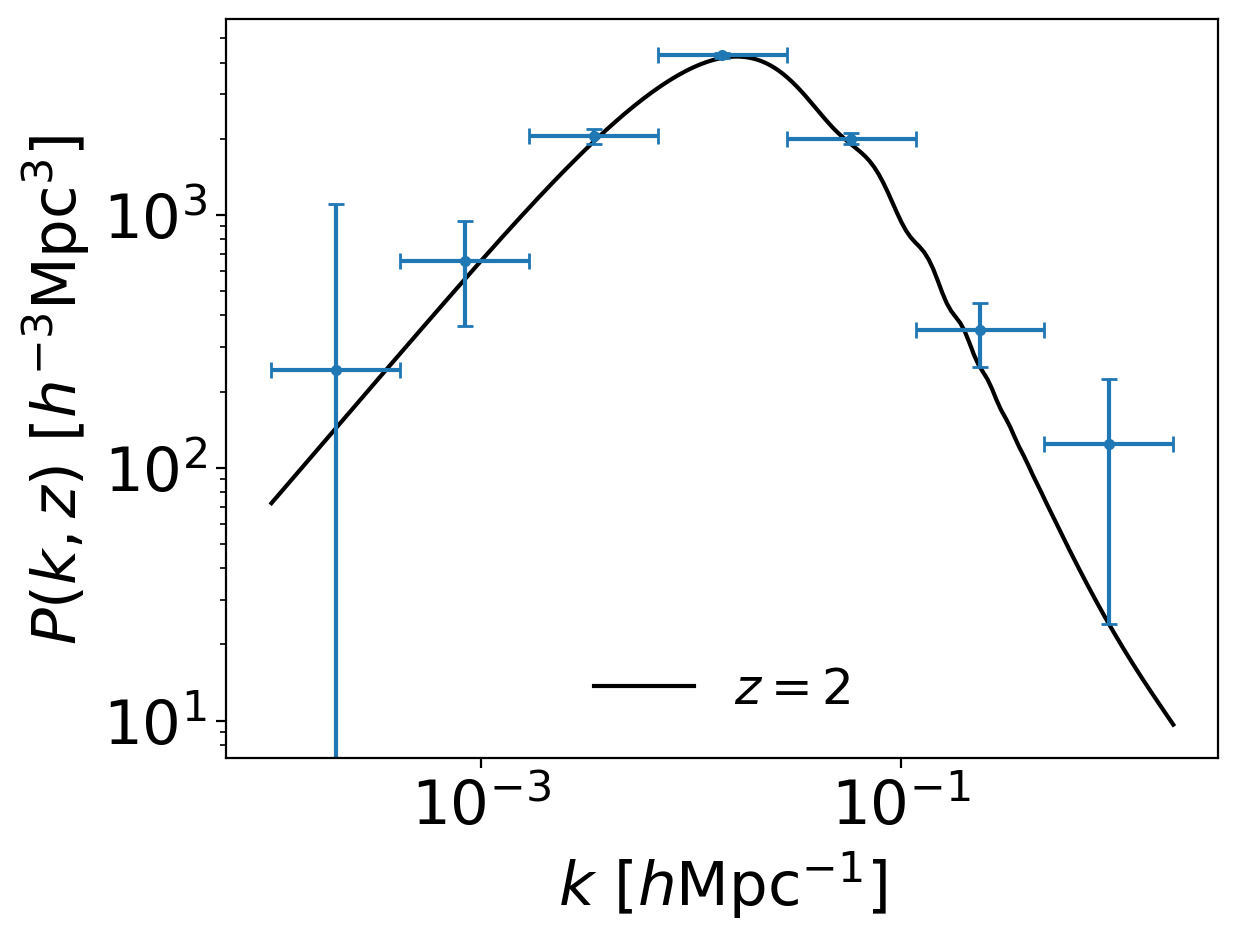

In [7]:
pk_interp = camb.get_matter_power_interpolator(pars_camb, 0, 10)
fig,ax=plt.subplots()
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    ax.loglog(kh, pk_nonlin[i,:], color='k', ls = line, label=r'$z=%d$'%redshift)
    errorbars = get_Pk_errorbars(k_bins, pk_interp, cosmoParams = pars_camb, surveyParams = surveyParams)
    print(errorbars.shape)
    ax.errorbar(errorbars[0,:], errorbars[1,:], yerr = errorbars[2,:], xerr = [errorbars[3,:],errorbars[4,:]],
                marker='.', ls='none', capsize=3)
ax.set_xlabel(r'$k\,\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k,z)\,\,[h^{-3}\mathrm{Mpc}^3]$')
ax.legend(frameon=False,fontsize=18)
plt.show()

# Weak lensing angular spectrum

### Tomographic power spectra

We first plot the signal term $P_{ij}^\kappa(\ell)\frac{\ell(\ell+1)}{2\pi},$ and then
$$C^\kappa_{ij}(\ell)\frac{\ell(\ell+1)}{2\pi} = \left(P_{ij}^\kappa(\ell)+\delta_{ij}\frac{\langle\epsilon^2_\mathrm{obs}\rangle}{\bar{n}_i}\right)\left(\frac{\ell(\ell+1)}{2\pi}\right),$$
where $\delta_{ij}\frac{\langle\epsilon^2_\mathrm{obs}\rangle}{\bar{n}_i}$ gives us the shot noise for auto-spectra of a single redshift bin.

Additionally, we plot error bars for the single-bin auto-spectra using eq. 14.45
\begin{align}
\sigma_{C^\kappa(\ell)}\equiv\mathrm{Cov}[C^\kappa(\ell),C^\kappa(\ell')]^{1/2}&=\sqrt{\frac{2\delta_{\ell\ell'}}{(2\ell+1)f_{\mathrm{sky}}}}\left[P^\kappa(\ell)+\frac{\langle\epsilon^2_{obs}\rangle}{\bar{n}}\right]\\
&=\sqrt{\frac{2\delta_{\ell\ell'}}{(2\ell+1)f_\mathrm{sky}}}C^\kappa(\ell)
\end{align}

In [8]:
nzs = [jc.redshift.smail_nz(1,2,1, gals_per_arcmin2=30), jc.redshift.smail_nz(1,2,.5, gals_per_arcmin2=5.59),jc.redshift.smail_nz(1,2,4, gals_per_arcmin2=5.59)]
probes = [jc.probes.WeakLensing(nzs, sigma_e = .261)]
ell = np.logspace(1,4,1000)
cls = jc.angular_cl.angular_cl(pars_jc, ell, probes)

/home/carter/.venv.camb/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


[]


In [9]:
#Cls are returned in order of bin, and then auto-spectra followed by cross-spectra. For example, if we have two bins, the Cls are returned in the order 11,12,22.
# For three bins, it should be 11,12,13,22,23,33
noise_cl = jc.angular_cl.noise_cl(ell, probes)
print(noise_cl.shape)
#plt.semilogx(ell, noise_cl[5,:])
print(nzs[0].gals_per_steradian)
print(nzs[0].gals_per_arcmin2)

(6, 1000)
354543085.8012684
30


In [10]:

def get_Cl_errorbars(ell_bins, f_sky, cl_index, probes, cosmoParams):
    dell = ell_bins[1:]-ell_bins[:-1]
    ell_sample = (ell_bins[1:]*ell_bins[:-1])**.5
    Cell_sample = jc.angular_cl.angular_cl(cosmoParams, ell_sample, probes)[cl_index]
    shotnoise = GAMMA_INT**2/nzs[0].gals_per_steradian
    sigma_cl = (2/((2*ell_sample+1)*f_sky*dell))**.5*(Cell_sample + shotnoise)
    sigma_cl = sigma_cl*ell_sample*(ell_sample+1)/(2*math.pi)
    errorbars = np.array([ell_sample, Cell_sample, sigma_cl, ell_sample[:]-ell_bins[:-1], ell_bins[1:]-ell_sample[:]])
    return errorbars

(10, 10000.0)

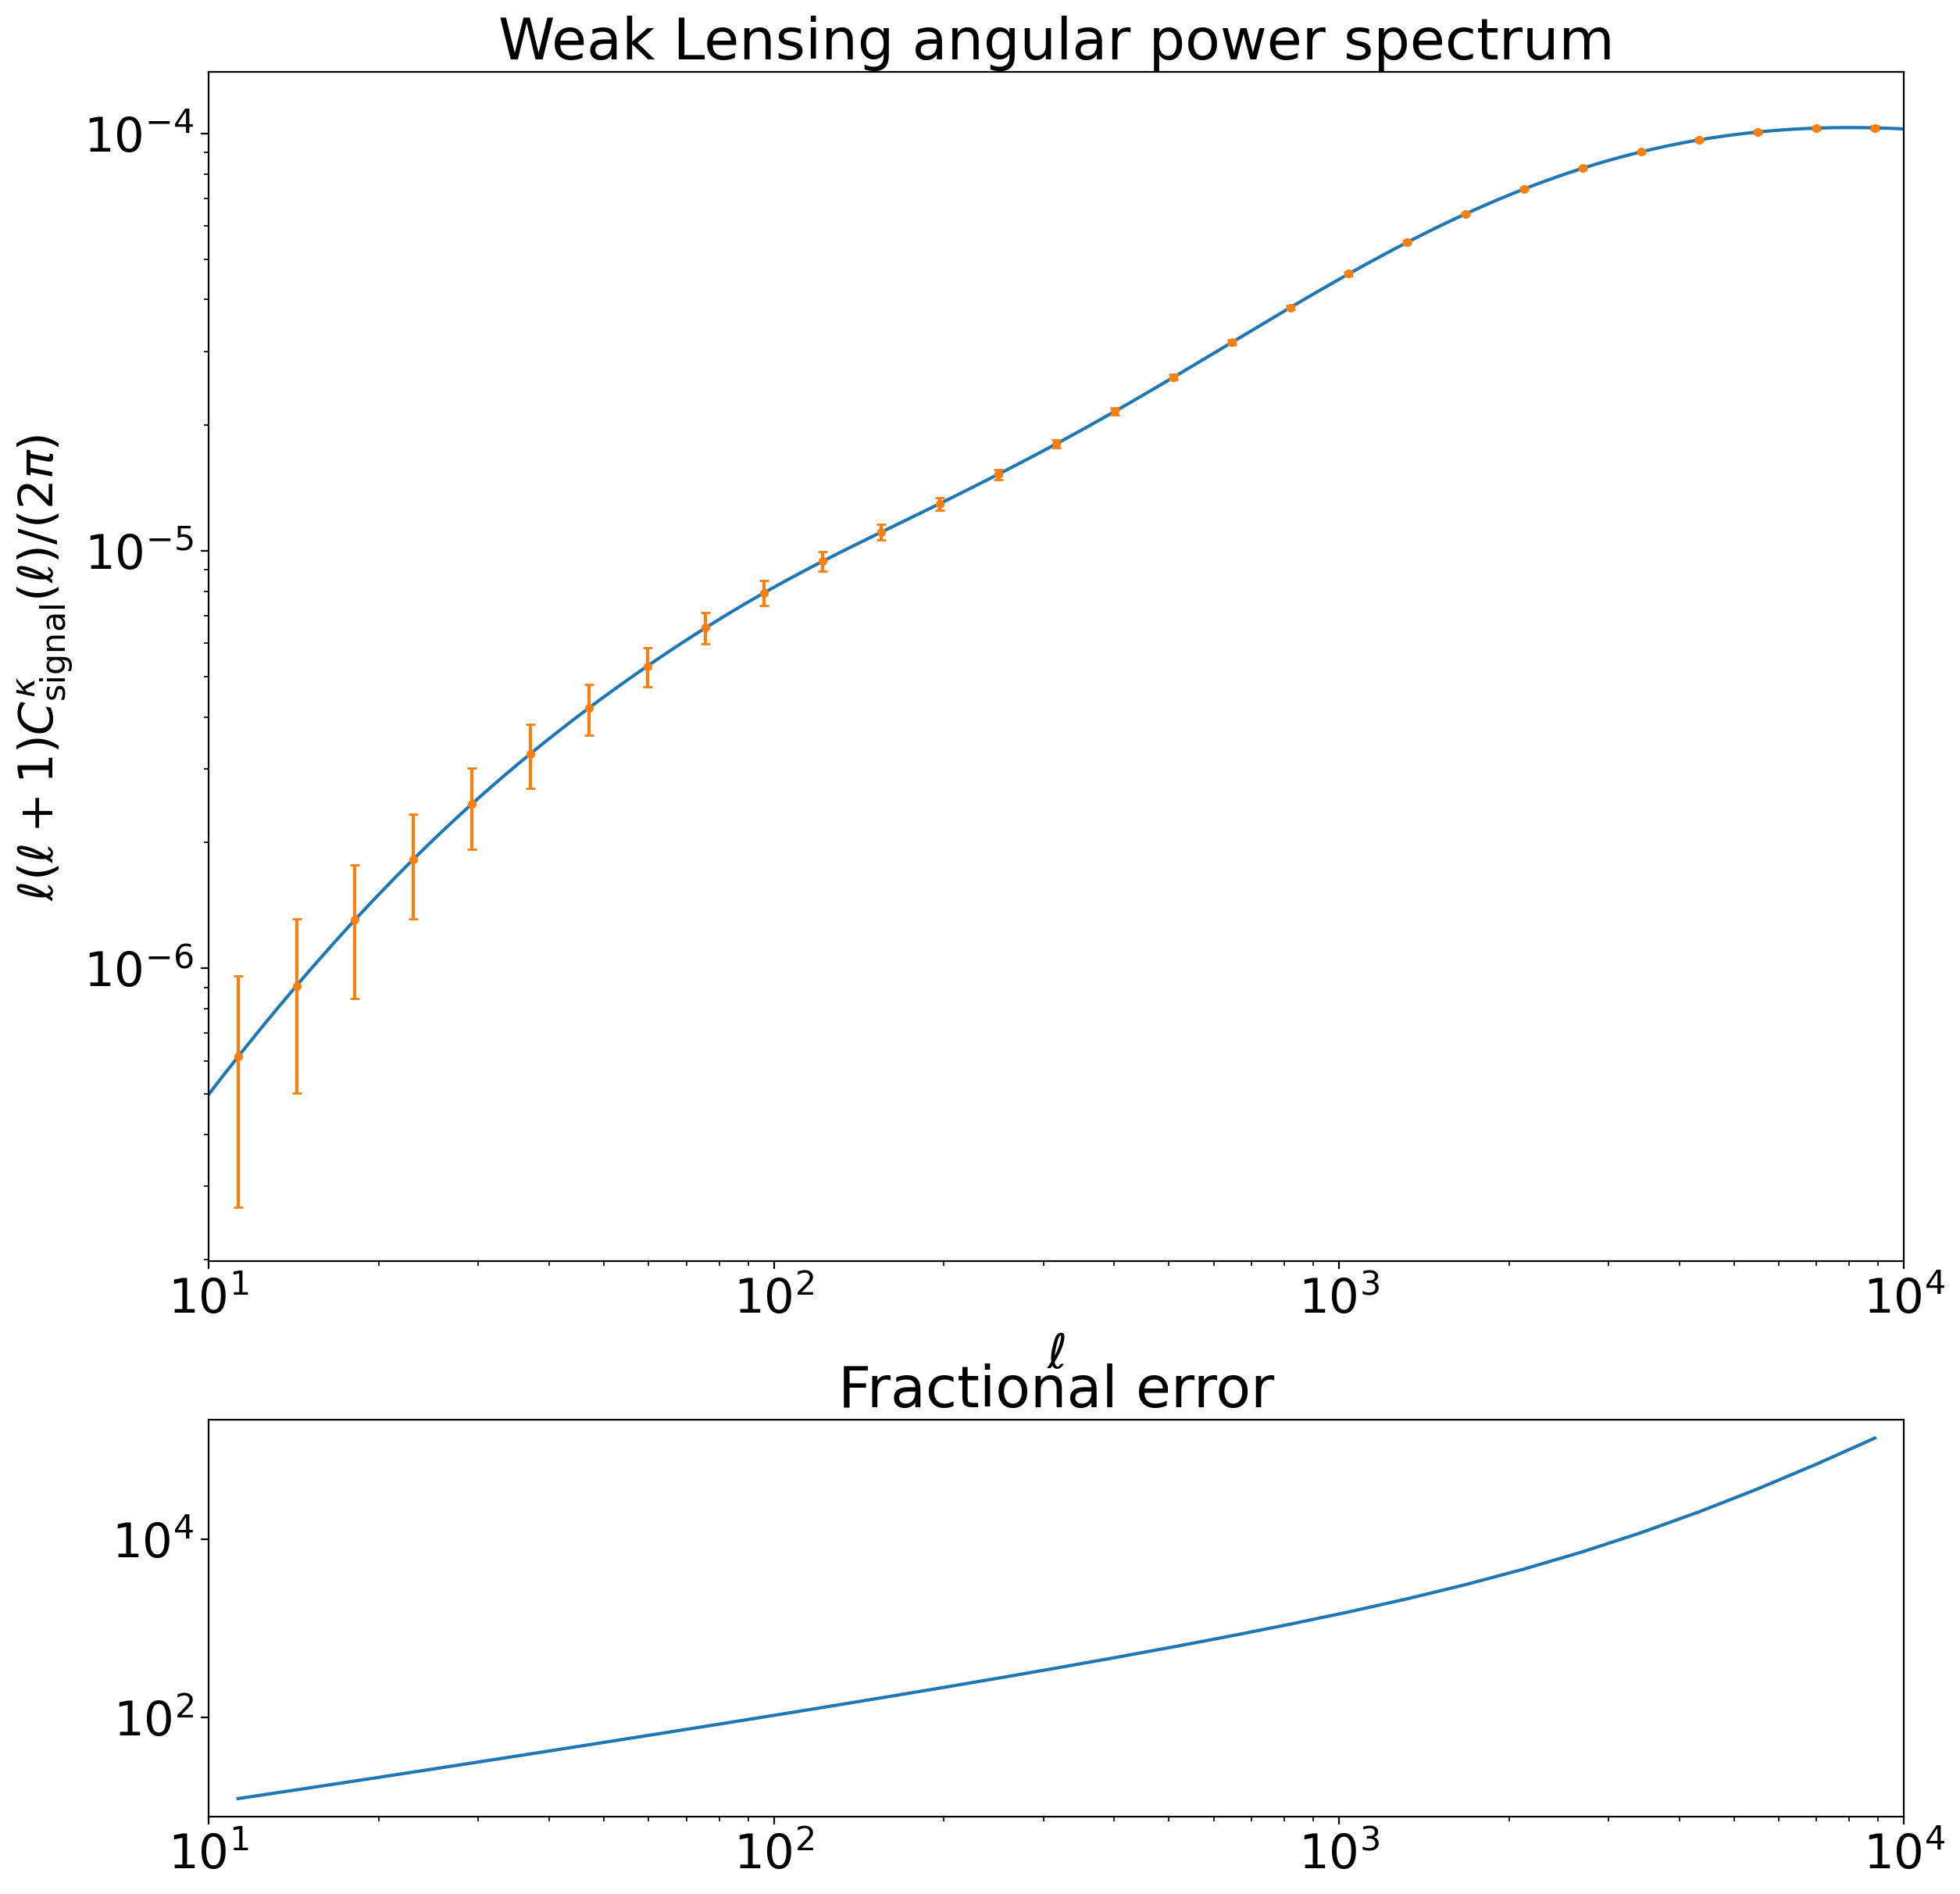

In [11]:
fig,ax = plt.subplots(2,1,height_ratios=[3,1], figsize=(14,14.5))
ax[0].loglog(ell, cls[0]*ell*(ell+1)/(2*math.pi), label=r'$11$')
#*ell*(ell+1)/(2*math.pi)
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\mathrm{signal}^\kappa(\ell)/(2\pi)$')
ax[0].set_title('Weak Lensing angular power spectrum')

errorbars = get_Cl_errorbars(np.logspace(1,4, 30), .1, 0, probes, pars_jc)
ax[0].errorbar(errorbars[0,:], errorbars[1,:]*errorbars[0,:]*(errorbars[0,:]+1)/(2*math.pi), yerr = errorbars[2,:], xerr = None, 
               ls='none', marker = '.', capsize=2)
#ax.errorbar(errorbars[0,:], errorbars[1,:], yerr = errorbars[2,:], ls='-', capsize=2)

ax[1].loglog(errorbars[0,:], errorbars[2,:]/errorbars[1,:])
ax[1].set_title('Fractional error')

ax[0].set_xlim((10,1e4))
ax[1].set_xlim((10,1e4))
#ax.loglog(ell, cls[0], label=r'$11$')

#Scale errorbars with *errorbars[0,:]*(errorbars[0,:]+1)/(2*math.pi)

## Redshift Binning

smail_nz: Returns Smail redshift distribution of the form $z^a\mathrm{exp}(-(\frac{z}{z_0})^b),$ normalized. Takes arguments in the order ($a,b,z_0$).

delta_nz: Returns a single plane redshift distribution at $z_0$. Takes the single parameter $z_0.$ -- seems fairly useless since for numerical stuff it returns the function $n(z)\neq 0$ when $z=z_0$, rather than $n(z)\neq 0$ when $z_0-\epsilon\leq z\leq z_0+\epsilon$

kde_nz: Returns an n(z) using a Gaussian kernel density estimate of an input redshift catalog with given weights for each object. Takes the parameters (redshift catalog, weights).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


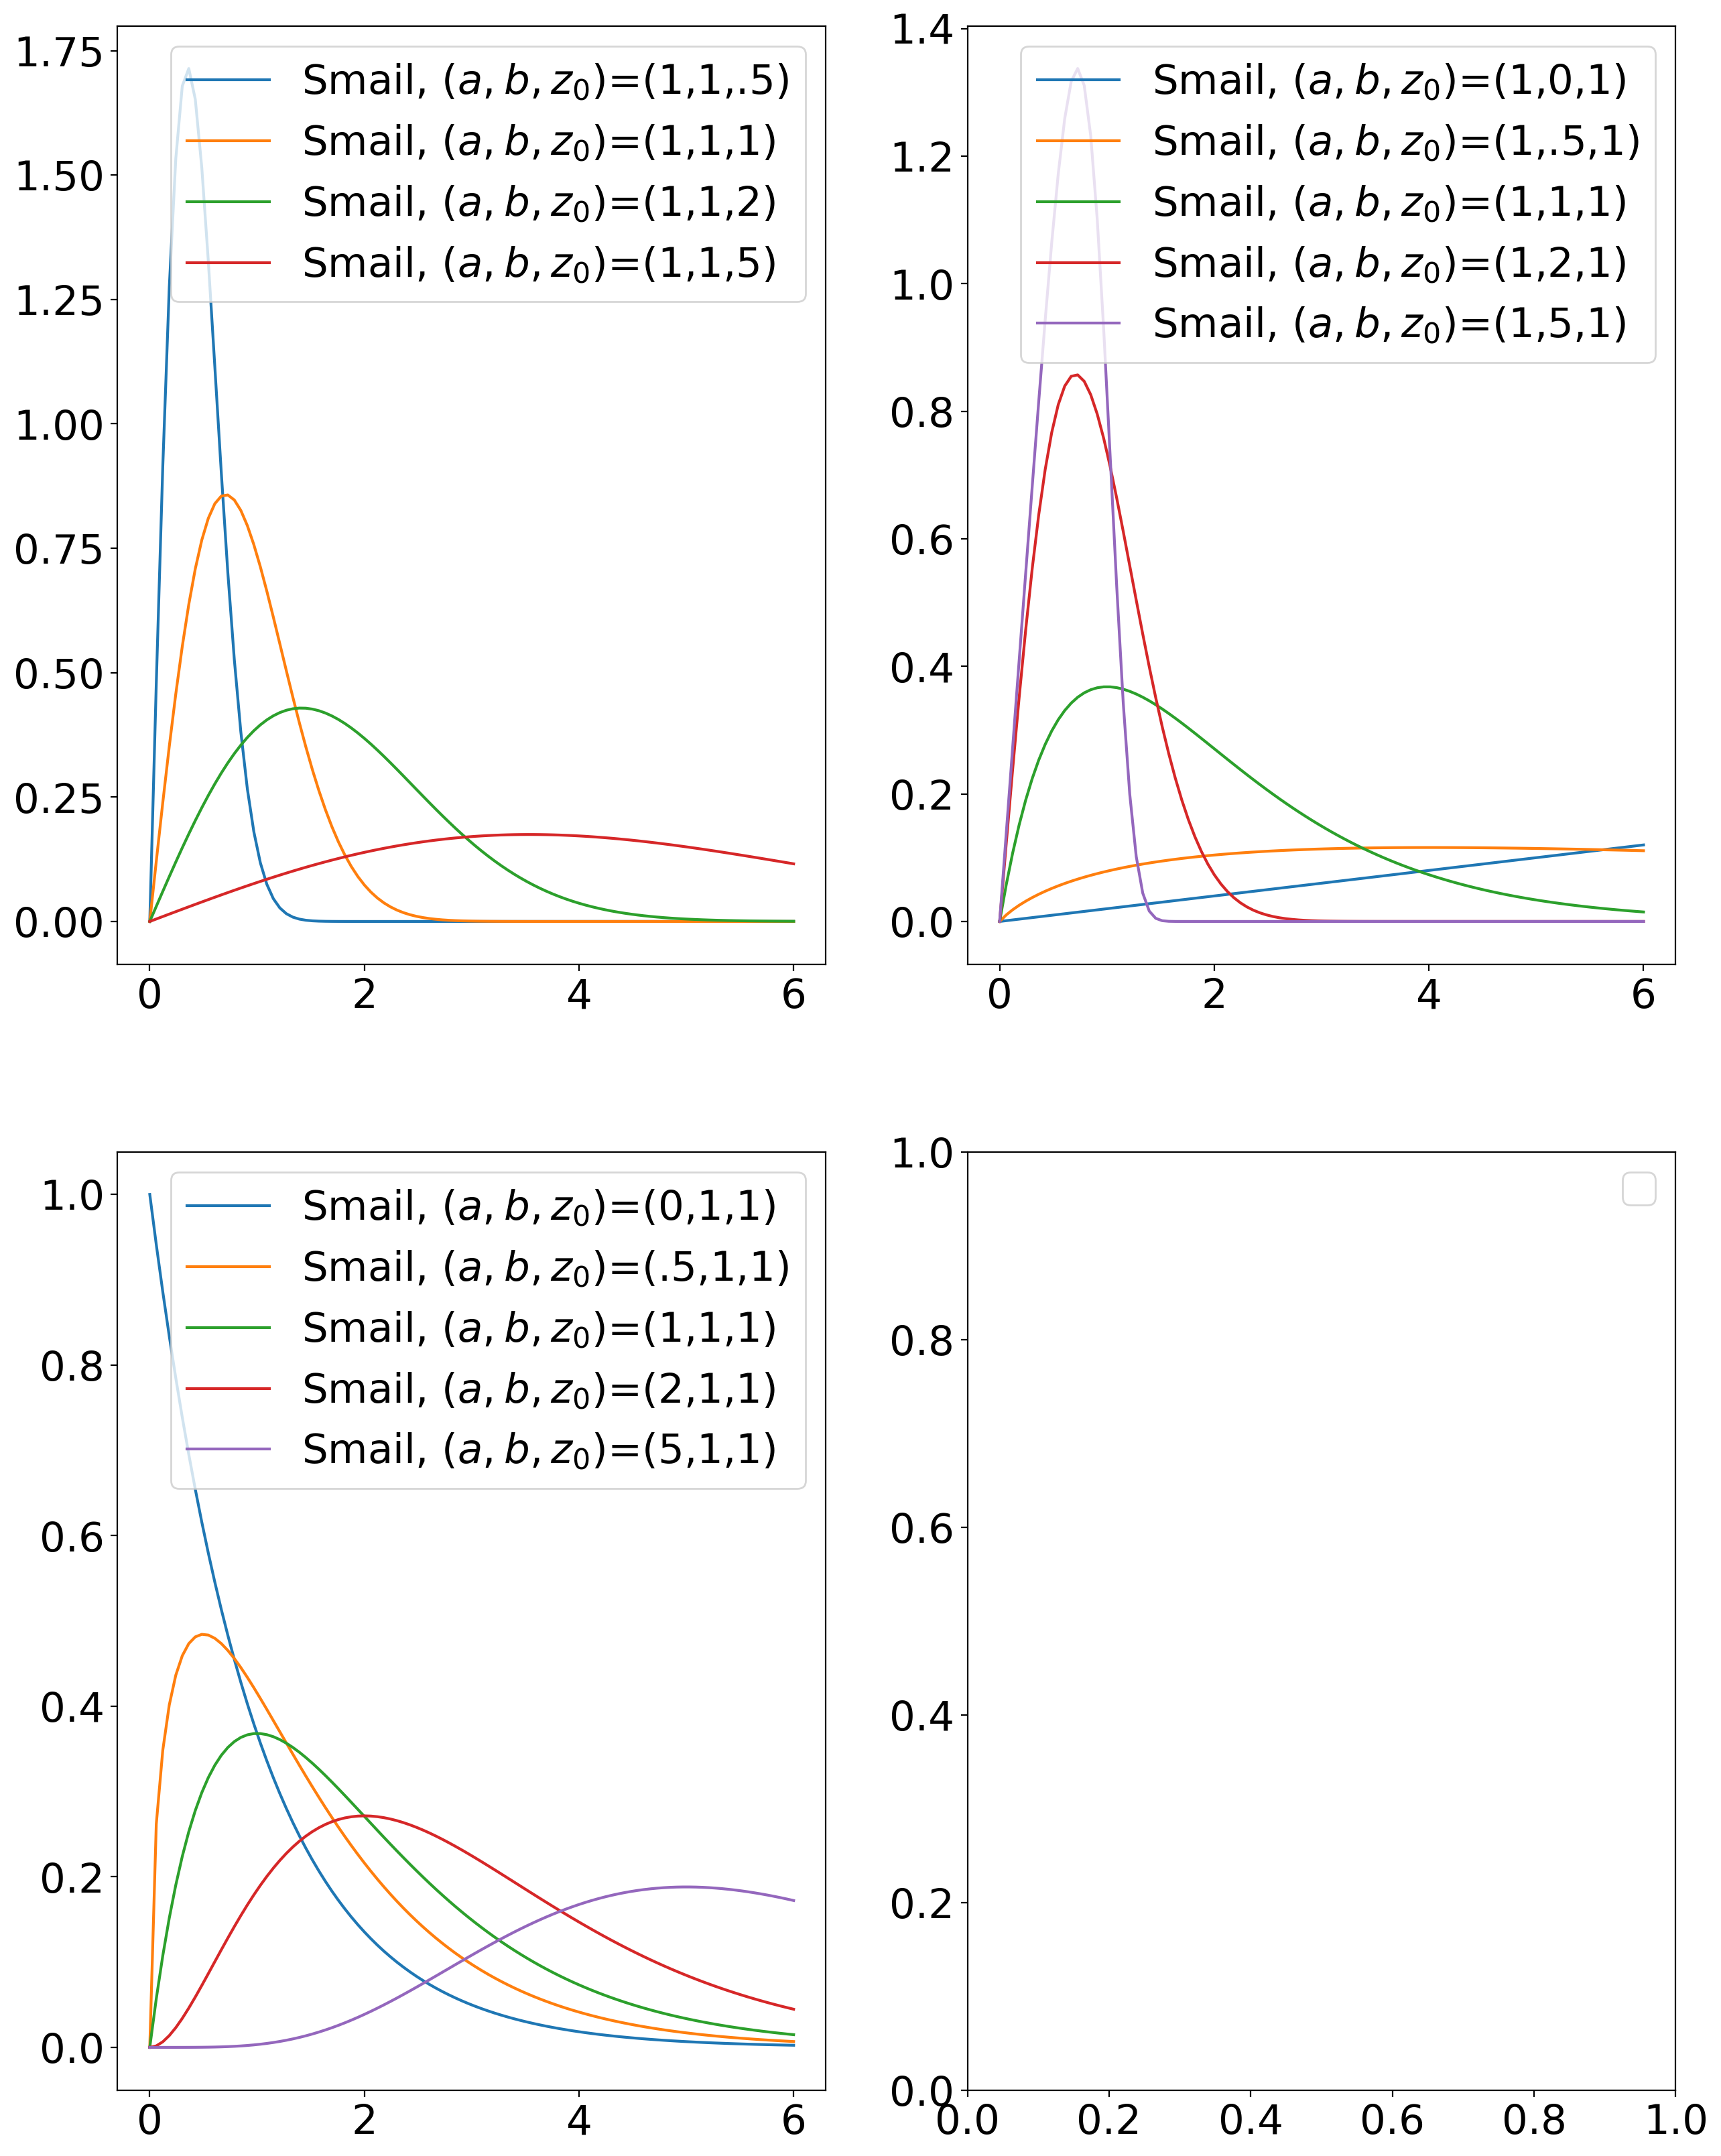

In [12]:
fig, ax = plt.subplots(2,2,figsize=(15,20))
z = np.linspace(0, 6, 100)
ax[0,0].plot(z, jc.redshift.smail_nz(1, 2, .5)(z), label=r'Smail, ($a,b,z_0$)=(1,1,.5)')
ax[0,0].plot(z, jc.redshift.smail_nz(1, 2, 1)(z), label=r'Smail, ($a,b,z_0$)=(1,1,1)')
ax[0,0].plot(z, jc.redshift.smail_nz(1, 2, 2)(z), label=r'Smail, ($a,b,z_0$)=(1,1,2)')
ax[0,0].plot(z, jc.redshift.smail_nz(1, 2, 5)(z), label=r'Smail, ($a,b,z_0$)=(1,1,5)')

ax[1,0].plot(z, jc.redshift.smail_nz(0, 1, 1)(z), label=r'Smail, ($a,b,z_0$)=(0,1,1)')
ax[1,0].plot(z, jc.redshift.smail_nz(.5, 1, 1)(z), label=r'Smail, ($a,b,z_0$)=(.5,1,1)')
ax[1,0].plot(z, jc.redshift.smail_nz(1, 1, 1)(z), label=r'Smail, ($a,b,z_0$)=(1,1,1)')
ax[1,0].plot(z, jc.redshift.smail_nz(2, 1, 1)(z), label=r'Smail, ($a,b,z_0$)=(2,1,1)')
ax[1,0].plot(z, jc.redshift.smail_nz(5, 1, 1)(z), label=r'Smail, ($a,b,z_0$)=(5,1,1)')

ax[0,1].plot(z, jc.redshift.smail_nz(1, 0, 1)(z), label=r'Smail, ($a,b,z_0$)=(1,0,1)')
ax[0,1].plot(z, jc.redshift.smail_nz(1, .5, 1)(z), label=r'Smail, ($a,b,z_0$)=(1,.5,1)')
ax[0,1].plot(z, jc.redshift.smail_nz(1, 1, 1)(z), label=r'Smail, ($a,b,z_0$)=(1,1,1)')
ax[0,1].plot(z, jc.redshift.smail_nz(1, 2, 1)(z), label=r'Smail, ($a,b,z_0$)=(1,2,1)')
ax[0,1].plot(z, jc.redshift.smail_nz(1, 5, 1)(z), label=r'Smail, ($a,b,z_0$)=(1,5,1)')

for plot in ax.flatten():
    plot.legend()
#print(jc.scipy.integrate(nzs[0], 0, 5))

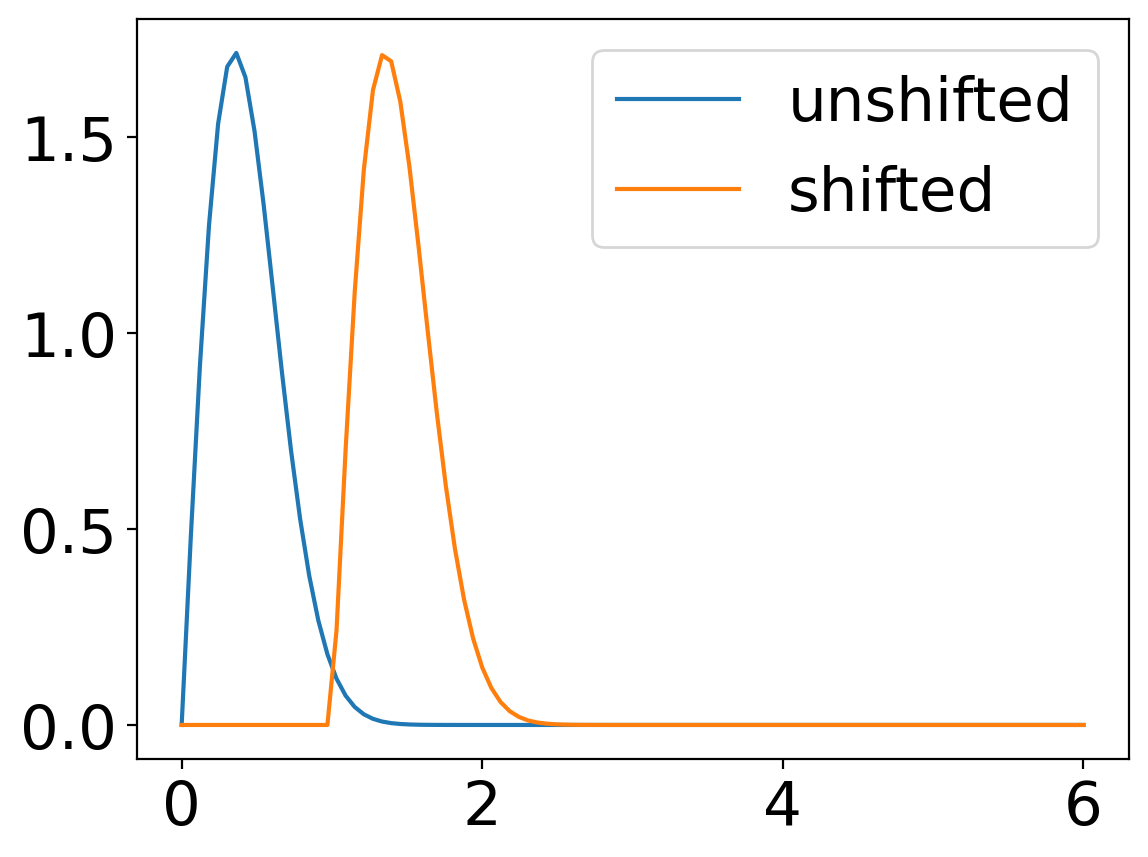

In [13]:
nz_shifted = jc.redshift.systematic_shift(jc.redshift.smail_nz(1,2,.5), 1, gals_per_arcmin2 = 30)
plt.plot(z, jc.redshift.smail_nz(1,2,.5)(z), label='unshifted')
plt.plot(z,nz_shifted(z), label='shifted')
plt.legend()

# Comparing values of $\gamma$

## Weak Lensing

In [14]:
pars_fiducial = jc.Planck15(gamma = .55)
pars_gamma_1 = jc.Planck15(gamma = .68)
pars_gamma_2 = jc.Planck15(gamma = .8)
pars_gamma_3 = jc.Planck15(gamma = .37)
print(pars_fiducial.gamma)

0.55


In [15]:
nz_base = jc.redshift.smail_nz(2,1.5,.9/math.sqrt(2), gals_per_arcmin2 = 30) #Distribution from arXiv:2306.12368
nzs = [jc.redshift.systematic_shift(nz_base, i) for i in np.linspace(0,1.8, 5)] #This method of generating redshift bins is incorrect, I should be generating a series of n_i(z) each with <30 gals/arcmin^2, such that when we sum each n_i(z) we get nz_base
ell = np.arange(10,1e5)
cls_fiducial = jc.angular_cl.angular_cl(pars_fiducial, ell, probes)
cls_1 = jc.angular_cl.angular_cl(pars_gamma_1, ell, probes)
cls_2 = jc.angular_cl.angular_cl(pars_gamma_2, ell, probes)
cls_3 = jc.angular_cl.angular_cl(pars_gamma_3, ell, probes)

# I had to modify jc.core.py to get it to compute C(ell) with gamma.
# In jax_cosmo.core.Cosmology.tree_unflatten, changed
# children = list(children[8:]).reverse()
# to
'''
children = list(children[8:])
children.reverse()'''

ell_bins = np.logspace(1,5, 50)

[Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=2/0)>]


(6, 99990)


Text(0.5, 1.0, 'WL Redshift Bins')

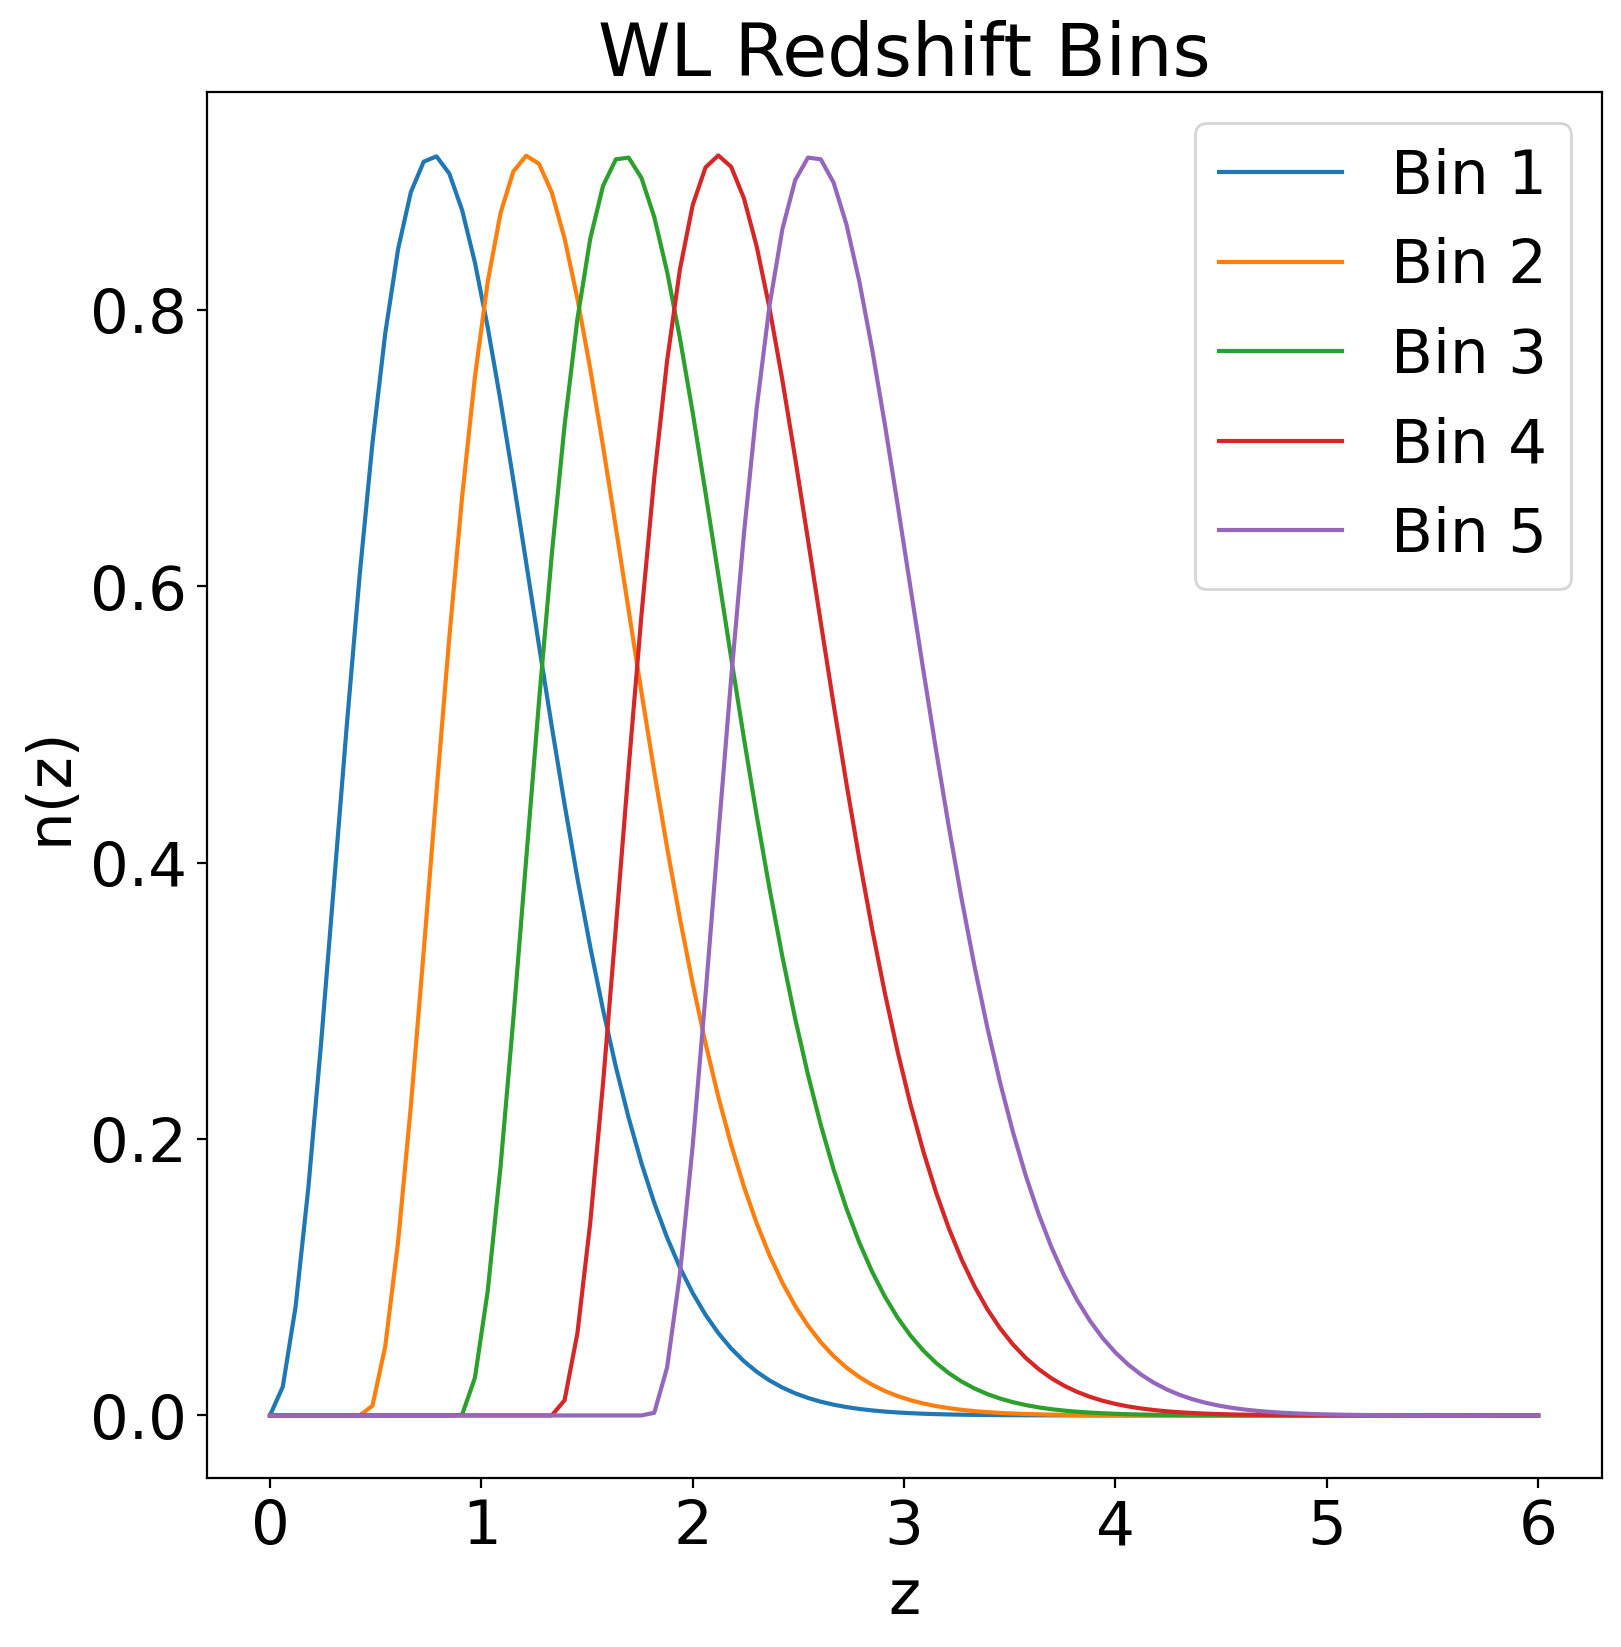

In [16]:
print(cls_fiducial.shape)
plt.figure(figsize= (9,9))
nz_total = jc.redshift.smail_nz(2,1.5,.9/math.sqrt(2), gals_per_arcmin2 = 30)

for i in np.arange(len(nzs)):
    plt.plot(z, nzs[i](z), label = r'Bin '+str(i+1))
plt.legend()
plt.xlabel('z')
plt.ylabel('n(z)')
plt.title('WL Redshift Bins')

In [17]:
ell_ell1 = ell*(ell+1)/(2*math.pi)
fiducial_errorbars = get_Cl_errorbars(ell_bins, .36, 0, probes, pars_fiducial)

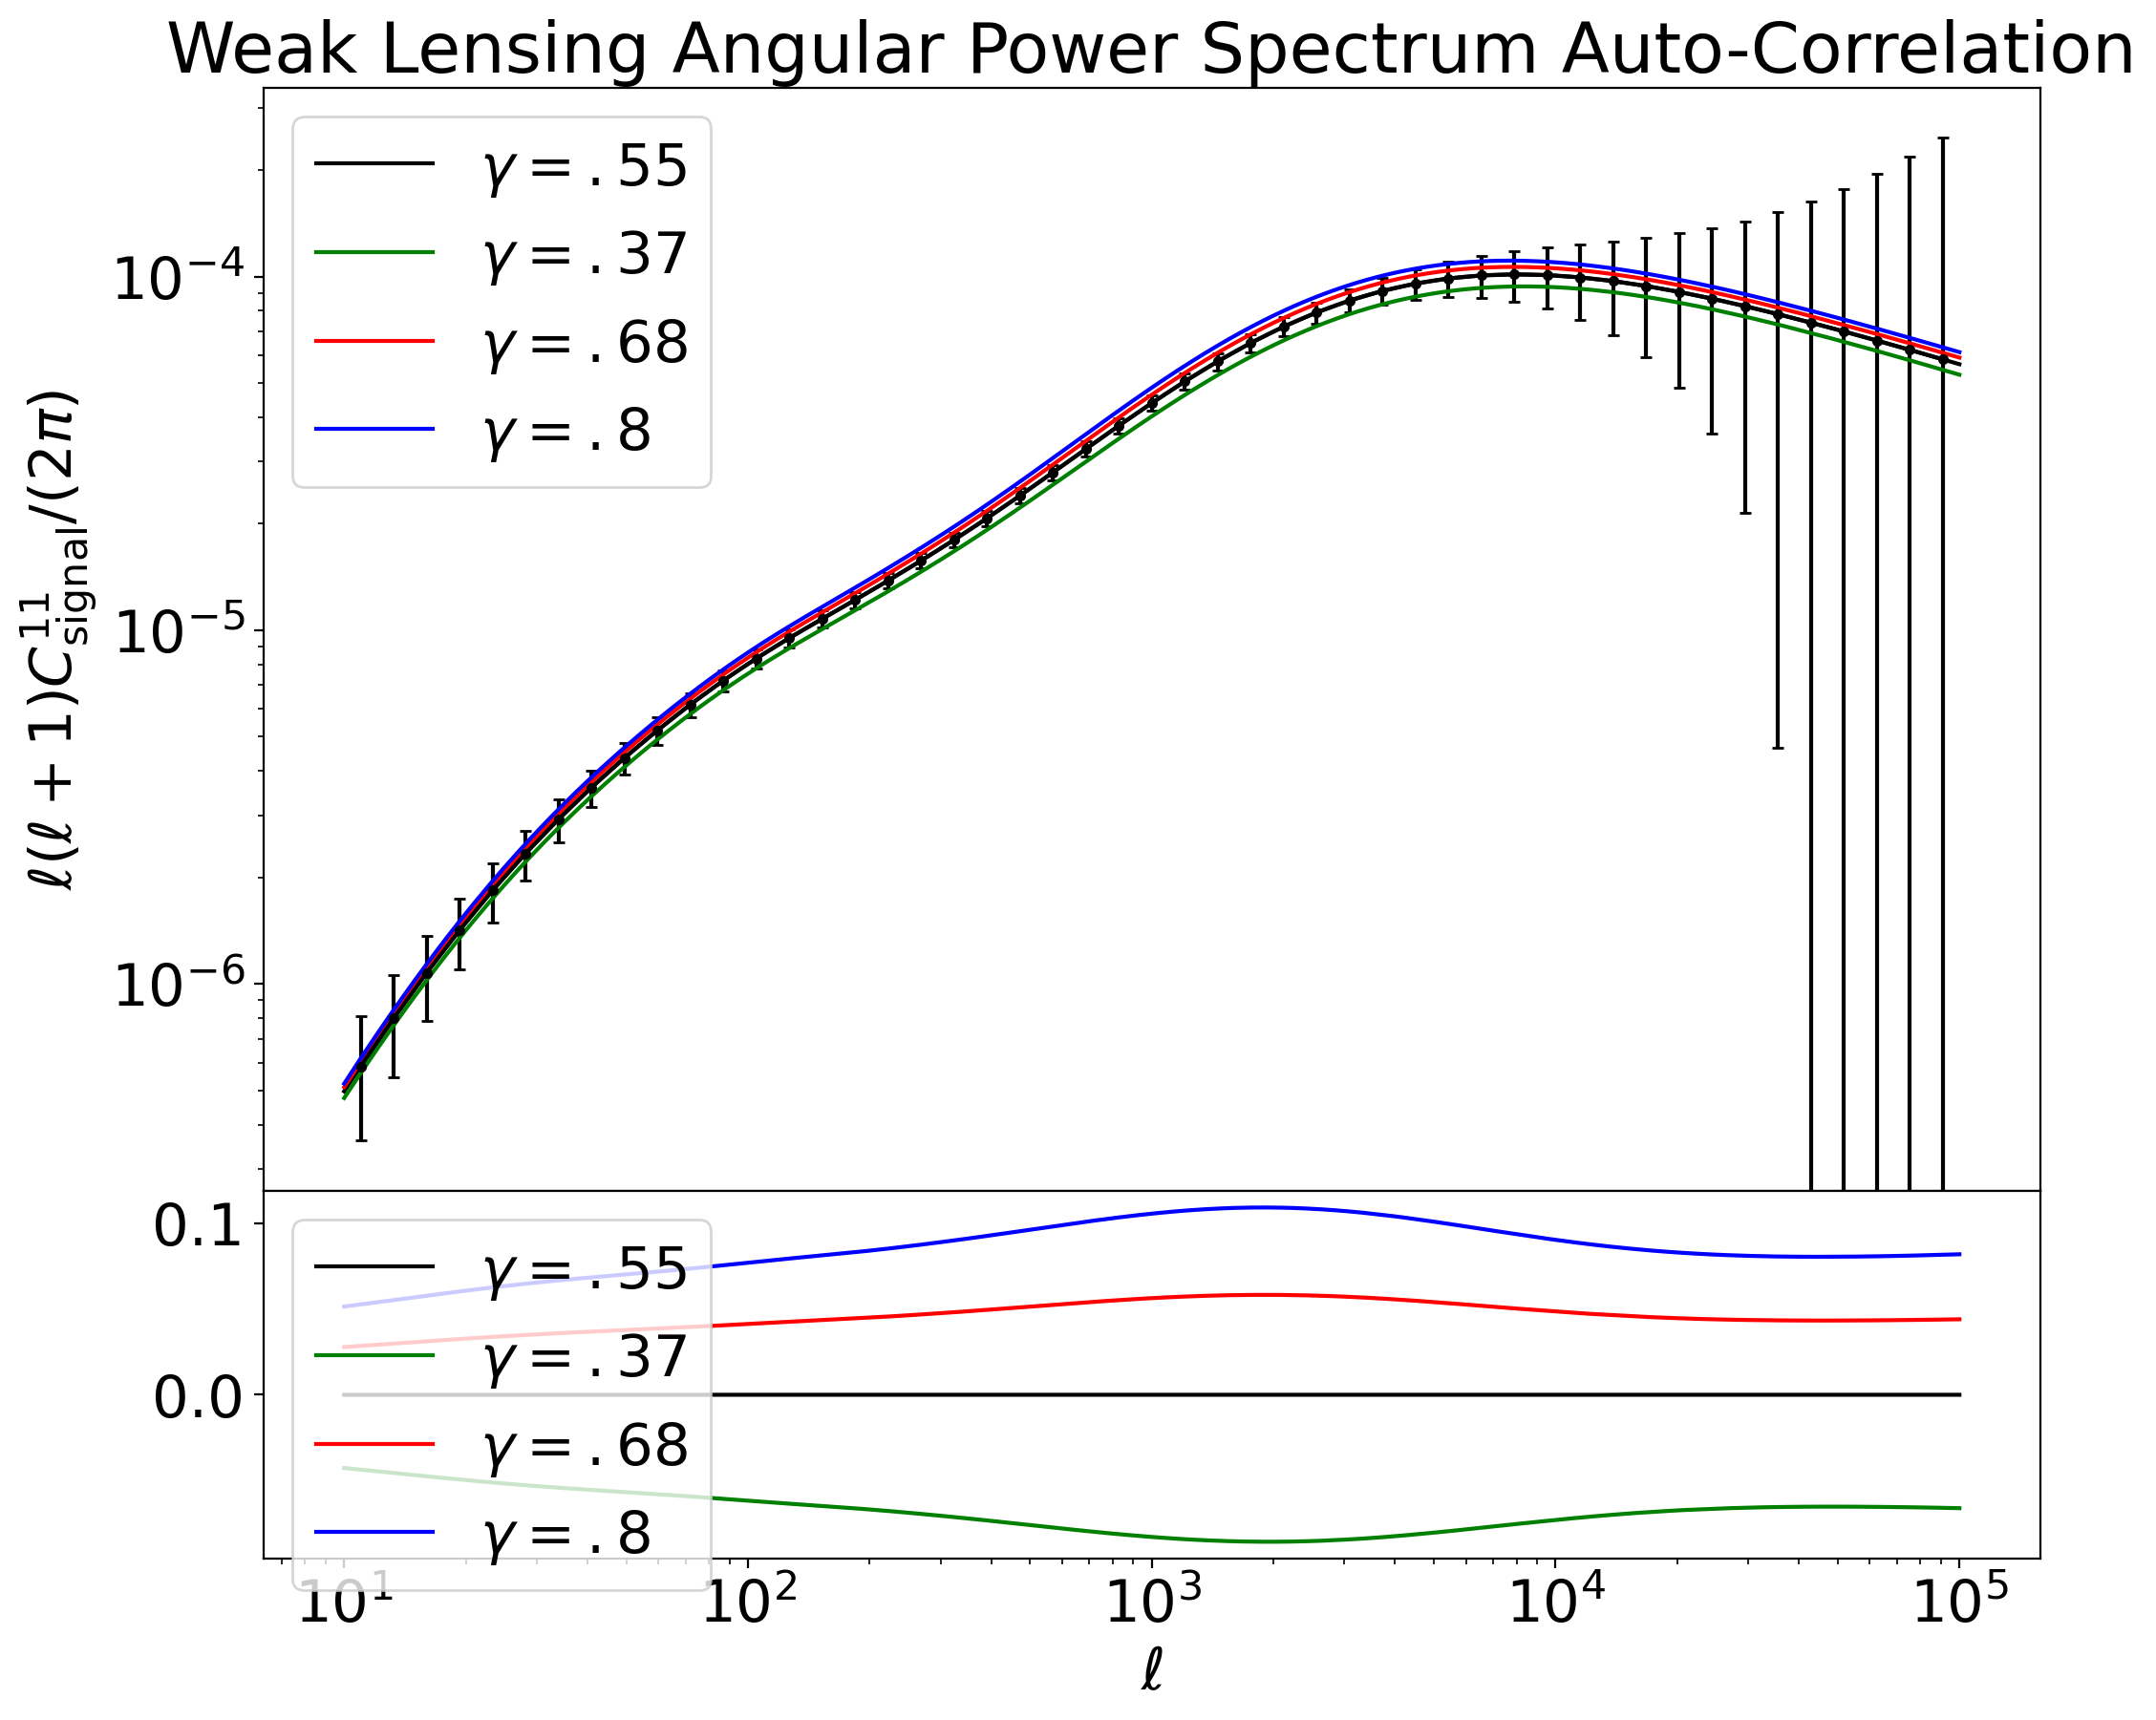

In [18]:
fig,ax = plt.subplots(2,1, figsize=(12,10), height_ratios = [3,1], sharex=True)
ax[0].loglog(ell, cls_fiducial[0]*ell_ell1, color='black', label=r'$\gamma = .55$')
ax[0].errorbar(fiducial_errorbars[0,:],fiducial_errorbars[1,:]*fiducial_errorbars[0,:]*(fiducial_errorbars[0,:]+1)/(2*math.pi),yerr=fiducial_errorbars[2,:],
               marker='.', capsize=2, color='black')

ax[0].loglog(ell, cls_3[0]*ell_ell1, color='green', label=r'$\gamma = .37$')
ax[0].loglog(ell, cls_1[0]*ell_ell1, color='red', label=r'$\gamma = .68$')
ax[0].loglog(ell, cls_2[0]*ell_ell1, color='blue', label=r'$\gamma = .8$')
ax[0].set_title('Weak Lensing Angular Power Spectrum Auto-Correlation')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\mathrm{signal}^{11}/(2\pi)$')
ax[1].set_xlabel(r'$\ell$')

ax[1].loglog(ell, (cls_fiducial[0]-cls_fiducial[0])/cls_fiducial[0], color='black', label=r'$\gamma = .55$')
ax[1].loglog(ell, (cls_3[0]-cls_fiducial[0])/cls_fiducial[0], color='green', label=r'$\gamma = .37$')
ax[1].loglog(ell, (cls_1[0]-cls_fiducial[0])/cls_fiducial[0], color='red', label=r'$\gamma = .68$')
ax[1].loglog(ell, (cls_2[0]-cls_fiducial[0])/cls_fiducial[0], color='blue', label=r'$\gamma = .8$')
ax[1].set_yscale('linear')

ax[0].legend()
ax[1].legend()

fig.subplots_adjust(hspace=0)

# CMB angular power spectrum

In [19]:
def get_CMB_cl_errorbars(ell_bins, Cell, f_sky):
    ell_sample = ((ell_bins[:-1]+ell_bins[1:])*.5)
    delta_T = 1
    theta_FWHM = 8.7e-4
    noise = delta_T**2*np.exp(ell_sample*(ell_sample+1)*theta_FWHM**2/(8*np.log(2)))
    dell = ell_bins[1:]-ell_bins[:-1]
    sigma2 = 2/((2*ell_sample+1)*f_sky*dell)*(Cell[ell_sample.astype(int)]+noise)**2
    error_y = sigma2**.5
    errorbars = np.array([ell_sample, Cell[ell_sample.astype(int)]+noise, error_y, ell_sample-ell_bins[:-1], ell_bins[1:]-ell_sample])
    return errorbars

In [20]:
pars_camb.set_for_lmax(2500)
results = camb.get_results(pars_camb)
powers = results.get_cmb_power_spectra(pars_camb, CMB_unit = 'muK')
totCL = powers['total']
ls = np.arange(totCL.shape[0])

Text(0.5, 1.0, 'CMB TT Angular Power Spectrum')

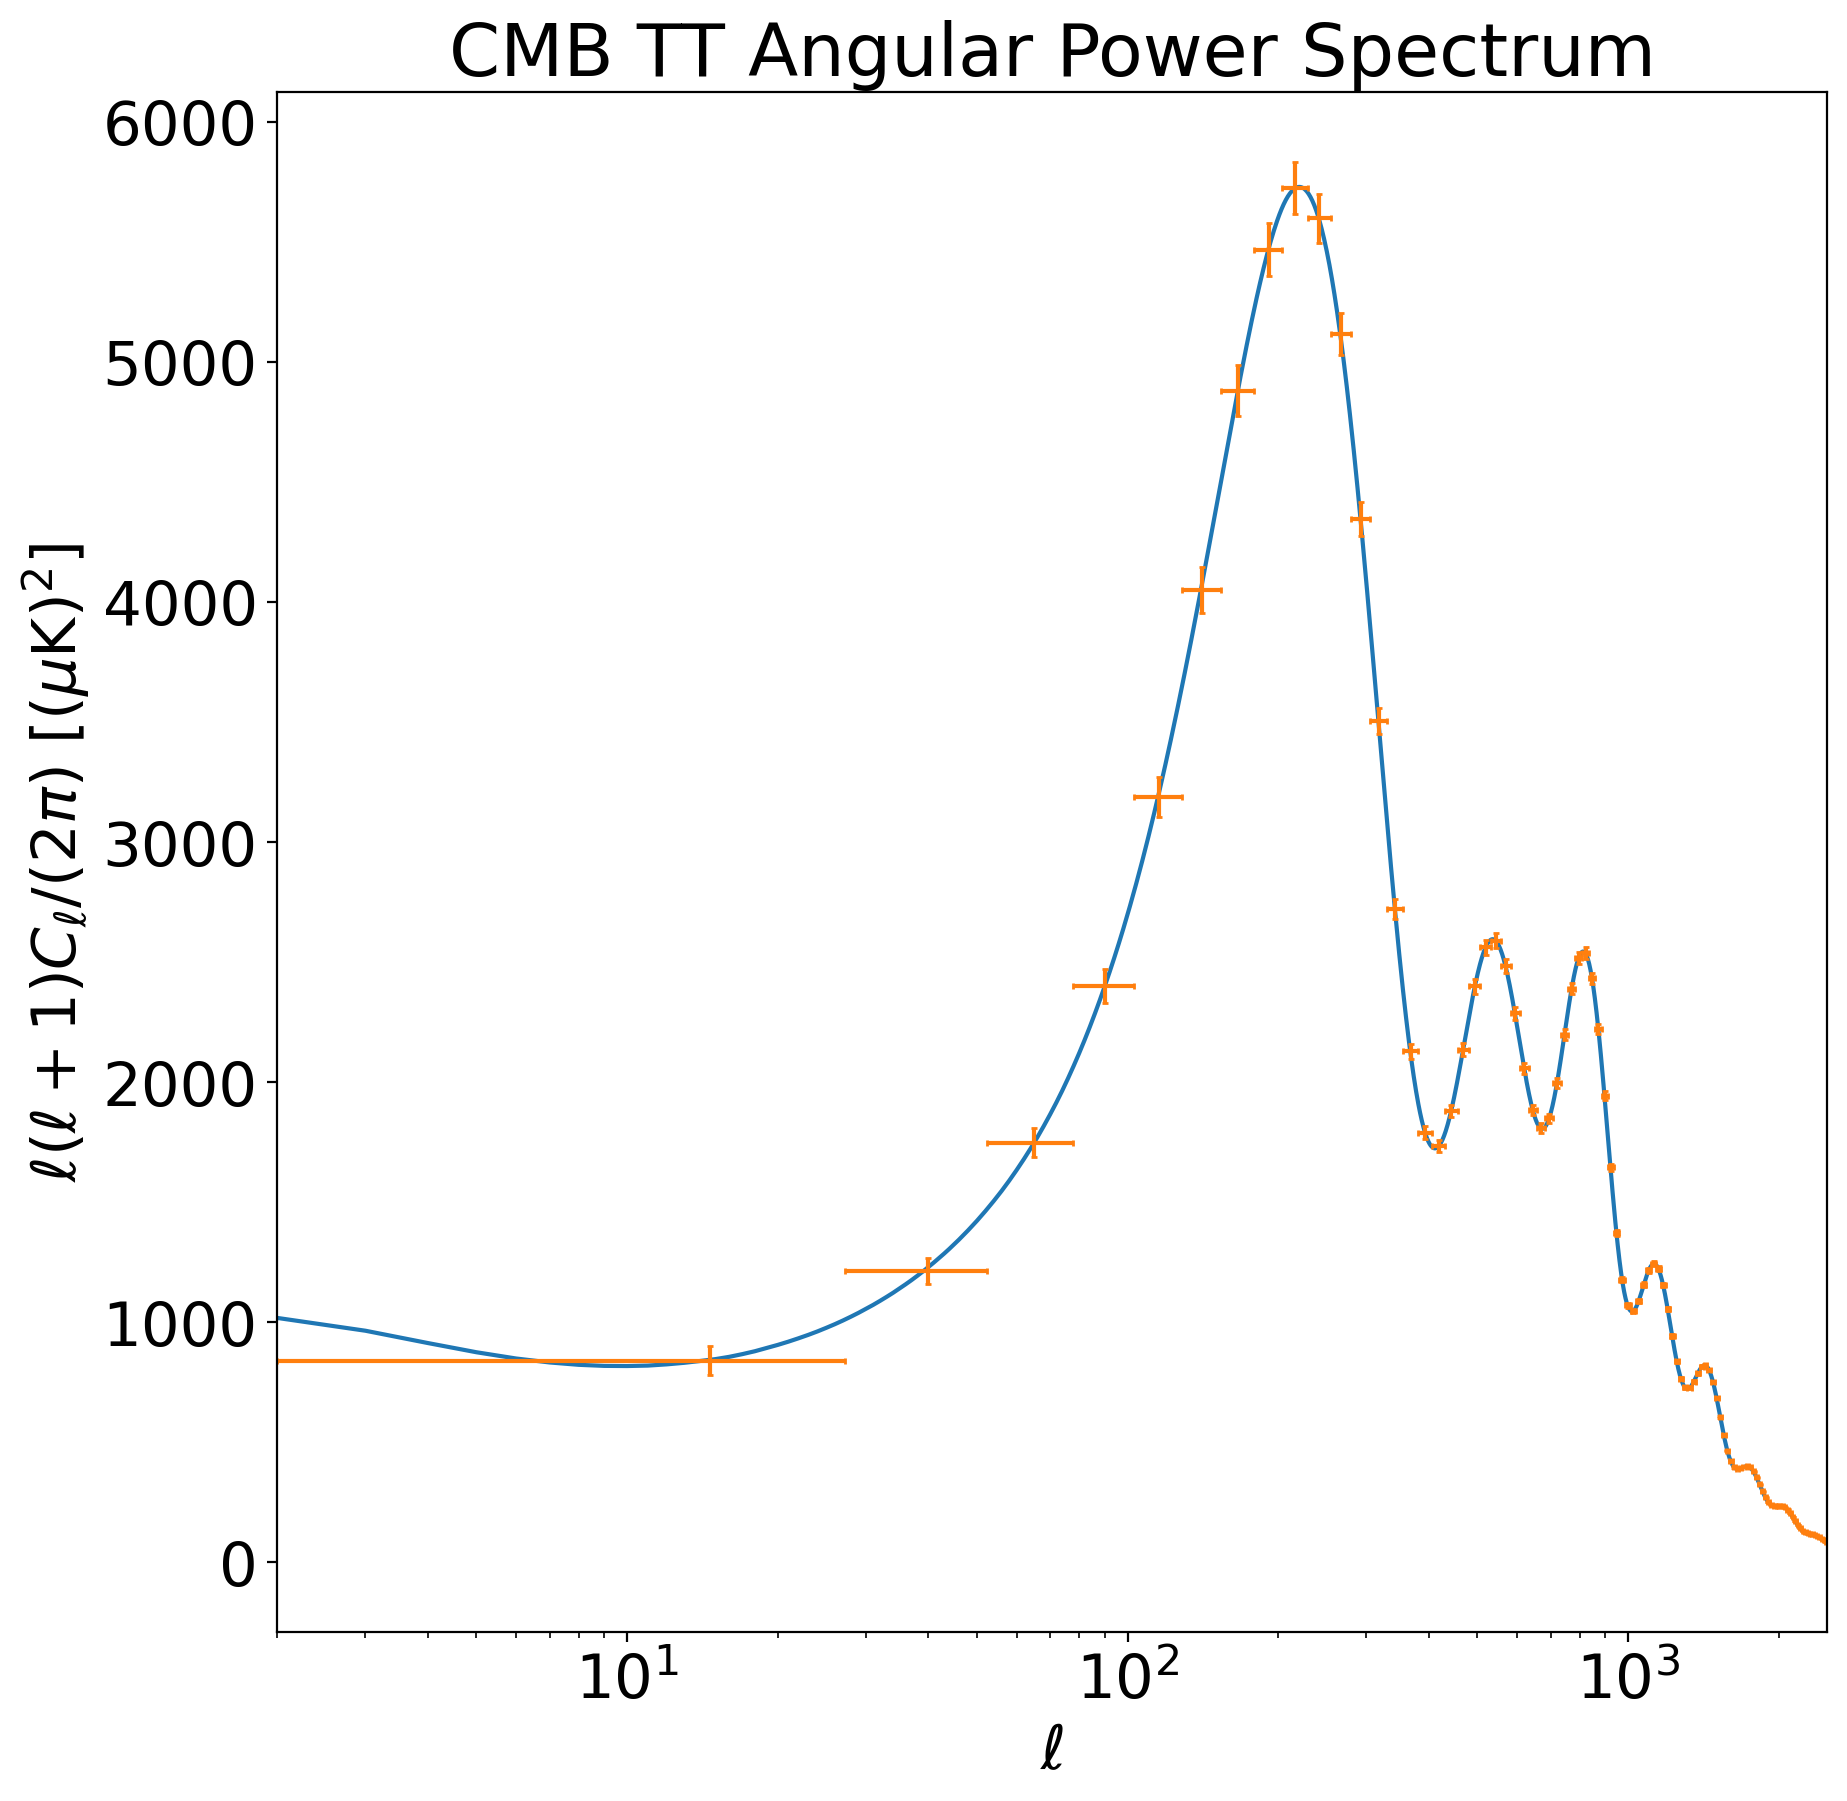

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.semilogx(ls, totCL[:,0])
errorbars = get_CMB_cl_errorbars(np.linspace(2,2500,100),totCL[:,0], .5)
ax.errorbar(errorbars[0],errorbars[1],errorbars[2],[errorbars[3],errorbars[4]], ls = 'none', capsize=1)
ax.set_xlim((2,2500))
ax.set_ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$ [$(\mu\mathrm{K})^2$]')
ax.set_xlabel(r'$\ell$')
ax.set_title('CMB TT Angular Power Spectrum')

In [22]:
print(errorbars.shape)

(5, 99)


# Building a Fisher Forecast

## With the Hessian

In [23]:
nz_base = jc.redshift.smail_nz(2,1.5,.9/math.sqrt(2), gals_per_arcmin2 = 30)
nzs = [jc.redshift.systematic_shift(nz_base, i) for i in np.linspace(0,1.8, 5)]
cosmo_fid = jc.Planck15(gamma=.55)
ell = np.logspace(1, 4, 50)
probes = [jc.probes.WeakLensing(nzs, sigma_e = .3)]
OMEGA_C_CONST = .2642 #Omega_c from Planck15

In [24]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_fid, ell, probes, sparse = True)
data = mu
params = np.array([cosmo_fid.gamma, cosmo_fid.Omega_m])

[Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=2/0)>]


In [25]:
@jax.jit
def likelihood(p):
    cosmo = jc.Planck15(gamma = p[0], Omega_b = p[1]-OMEGA_C_CONST)
    m, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, sparse = True)

    P = jc.sparse.inv(jax.lax.stop_gradient(C))
    r = data - m
    return -.5*r.T @jc.sparse.sparse_dot_vec(P,r)

In [26]:
print(likelihood(params))
print(likelihood(np.array([.68, cosmo_fid.Omega_m])))

[Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>]
-14.558077
-202.57745


In [27]:
hessian_loglik = jax.jit(jax.hessian(likelihood))
F = - hessian_loglik(params)

2023-06-27 21:41:26.891157: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_likelihood] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-06-27 22:01:13.011953: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 21m46.120908347s

********************************
[Compiling module jit_likelihood] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [28]:
print(F)

[[  38210.22  187780.47]
 [ 187780.44 1067031.4 ]]


In [29]:
#TODO Not a very good way to do this, need to rewrite using matplotlib Ellipse. Method from jc ex. notebook has some issues, it'll probably be easier to just write my own method.
from matplotlib.patches import Ellipse
def plot_contours_slow(fisher, pos, ax, dchi2 = 2.3, xlim = (.5,.6), ylim = (.25,.35),
                  color = 'red', label=''):
    G11 = fisher[0,0]
    G12 = fisher[0,1]
    G22 = fisher[1,1]
    x = np.linspace(xlim[0], xlim[1], 1000)
    y = np.linspace(ylim[0], ylim[1], 1000)
    x,y = np.meshgrid(x,y)
    func = G11*(x-pos[0])**2+2*G12*(x-pos[0])*(y-pos[1])+G22*(y-pos[1])**2-dchi2
    ax.contour(x,y,func, [0], colors=[color], label=label)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

/tmp/ipykernel_62813/116595292.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(x,y,func, [0], colors=[color], label=label)


Text(0, 0.5, '$\\Omega_m$')

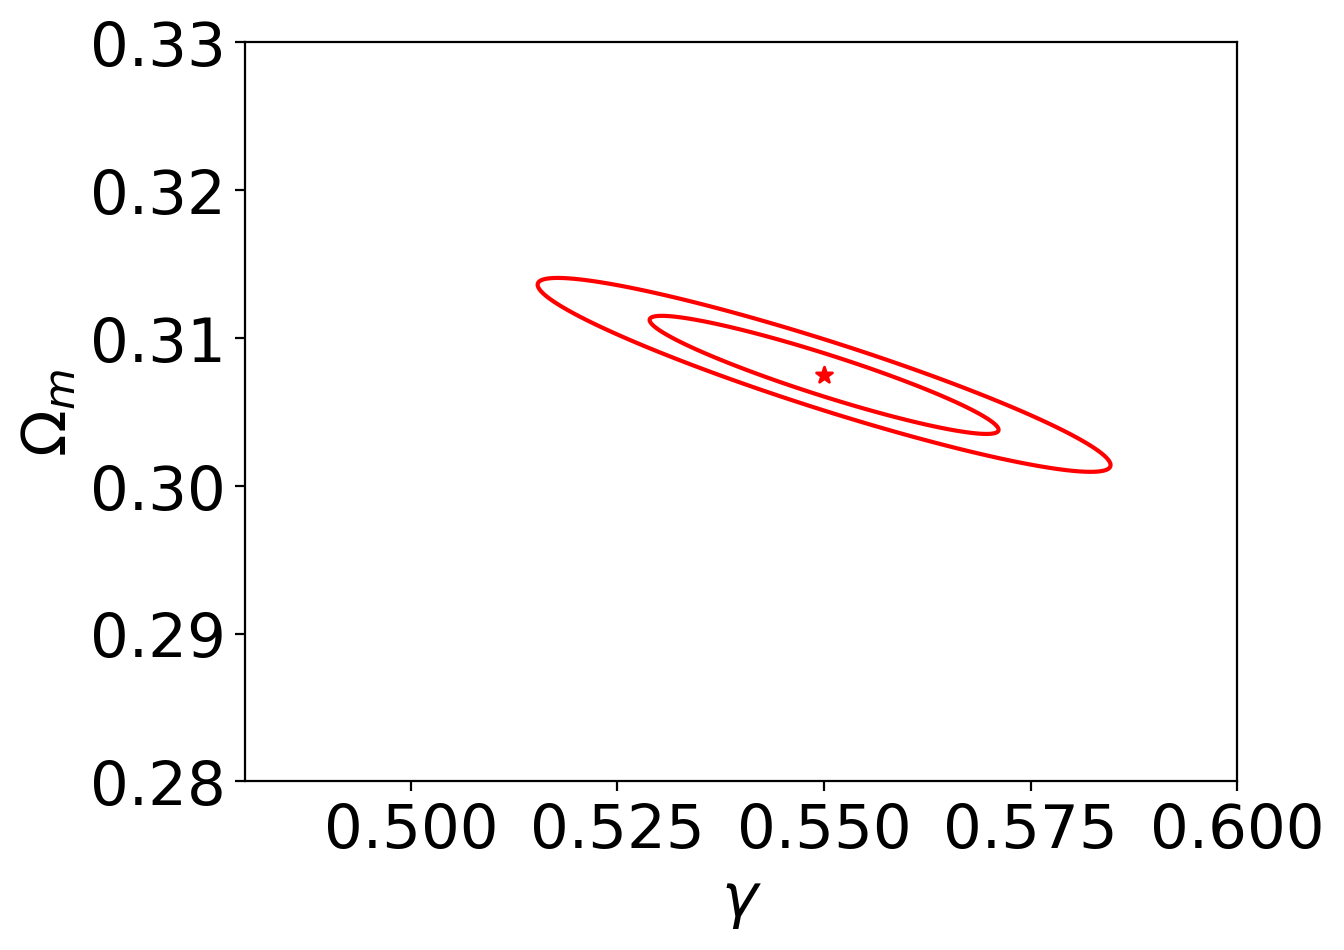

In [31]:
fig,ax = plt.subplots(1,1)
plot_contours_slow(F, [cosmo_fid.gamma, cosmo_fid.Omega_m], ax, xlim = (.52,.58), ylim = (.28,.33))
plot_contours_slow(F, [cosmo_fid.gamma, cosmo_fid.Omega_m], ax, xlim = (.48,.6), ylim = (.28,.33), dchi2 = 6.2)
ax.scatter(cosmo_fid.gamma, cosmo_fid.Omega_m, color='red', marker='*')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\Omega_m$')

## With the covariance matrix

In [32]:
params = np.array([cosmo_fid.gamma, cosmo_fid.Omega_m])
def mean_fn(p):
    cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
    m = jc.angular_cl.angular_cl(cosmo, ell, probes)
    return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))

In [33]:
dmu = jac_mean(params)

/home/carter/.venv.camb/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


[]


In [34]:
F_2 = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)

/tmp/ipykernel_62813/116595292.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(x,y,func, [0], colors=[color], label=label)


Text(0, 0.5, '$\\Omega_m$')

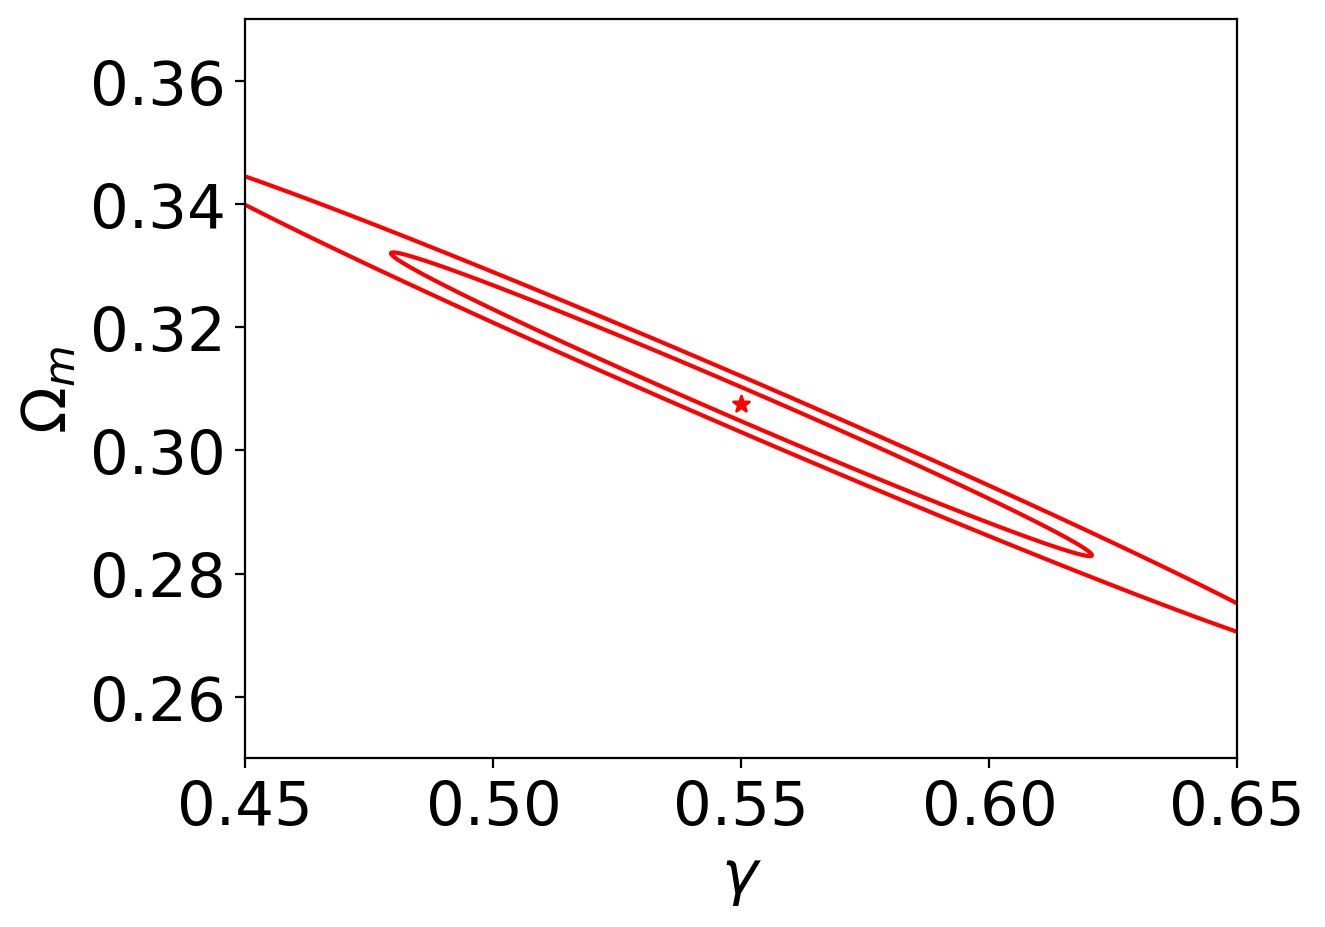

In [35]:
fig,ax = plt.subplots(1,1)
plot_contours_slow(F_2, [cosmo_fid.gamma, cosmo_fid.Omega_m], ax, xlim = (.45,.65), ylim = (.25,.37), dchi2 = 2.3)
plot_contours_slow(F_2, [cosmo_fid.gamma, cosmo_fid.Omega_m], ax, xlim = (.45,.65), ylim = (.25,.37), dchi2 = 6.2)
ax.scatter(cosmo_fid.gamma, cosmo_fid.Omega_m, color='red', marker='*')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\Omega_m$')